In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Isolate torch_geometric imports
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_dense_adj
import random


### Load RNA dataset

In [2]:
dict_dataset = {
    'GPN15k': pd.read_csv('data/GPN15k_silico_predictions.csv'),
    'PK50': pd.read_csv('data/PK50_silico_predictions.csv'),
    'PK90': pd.read_csv('data/PK90_silico_predictions.csv'),
    'R1': pd.read_csv('data/R1_silico_predictions.csv'),
}

RNA_sequences = []
RNA_structures = []

for k, df_data in dict_dataset.items():
    df_data = df_data[~df_data.vienna2_mfe.str.contains('x')]
    RNA_sequences = RNA_sequences + df_data.sequence.to_list()
    RNA_structures = RNA_structures + df_data.vienna2_mfe.to_list()
    print(k, len(df_data))

GPN15k 15000
PK50 2729
PK90 2173
R1 119999


In [3]:
from sklearn.model_selection import train_test_split

RNA_seq_train_val, RNA_seq_test, RNA_struct_train_val, RNA_struct_test = train_test_split(RNA_sequences, RNA_structures, test_size=0.2, random_state=42, shuffle=True)

RNA_seq_train, RNA_seq_val, RNA_struct_train, RNA_struct_val = train_test_split(
    RNA_seq_train_val, RNA_struct_train_val, test_size=0.15, random_state=42)  

print(len(RNA_seq_train), len(RNA_seq_test), len(RNA_seq_val))
print(len(RNA_struct_train), len(RNA_struct_test),len(RNA_struct_val))


95132 27981 16788
95132 27981 16788


### Build Graph

In [4]:
def build_graph(sequence, structure):
    base_to_idx = {'A': 0, 'U': 1, 'G': 2, 'C': 3}
    struct_to_idx = {'.': 0, '(': 1, ')': 2}
    
    node_features = []
    for base, struct in zip(sequence, structure):
        base_feature = [0, 0, 0, 0]
        base_feature[base_to_idx[base]] = 1
        struct_feature = [0, 0, 0]
        struct_feature[struct_to_idx[struct]] = 1
        node_features.append(base_feature + struct_feature)
    
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    edges = []
    stack = []
    for i, (base, struct) in enumerate(zip(sequence, structure)):
        if i > 0:
            edges.append((i-1, i))
            edges.append((i, i-1))
        
        if struct == '(':
            stack.append(i)
        elif struct == ')' and stack:
            j = stack.pop()
            edges.append((i, j))
            edges.append((j, i))
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return Data(x=node_features, edge_index=edge_index)

# Convert data to graphs
graphs_train = [build_graph(seq, struct) for seq, struct in zip(RNA_seq_train, RNA_struct_train)]
graphs_test = [build_graph(seq, struct) for seq, struct in zip(RNA_seq_test, RNA_struct_test)]
graphs_val = [build_graph(seq, struct) for seq, struct in zip(RNA_seq_val, RNA_struct_val)]

In [5]:
import draw_rna
from draw_rna import ipynb_draw
from draw_rna.ipynb_draw import draw_struct

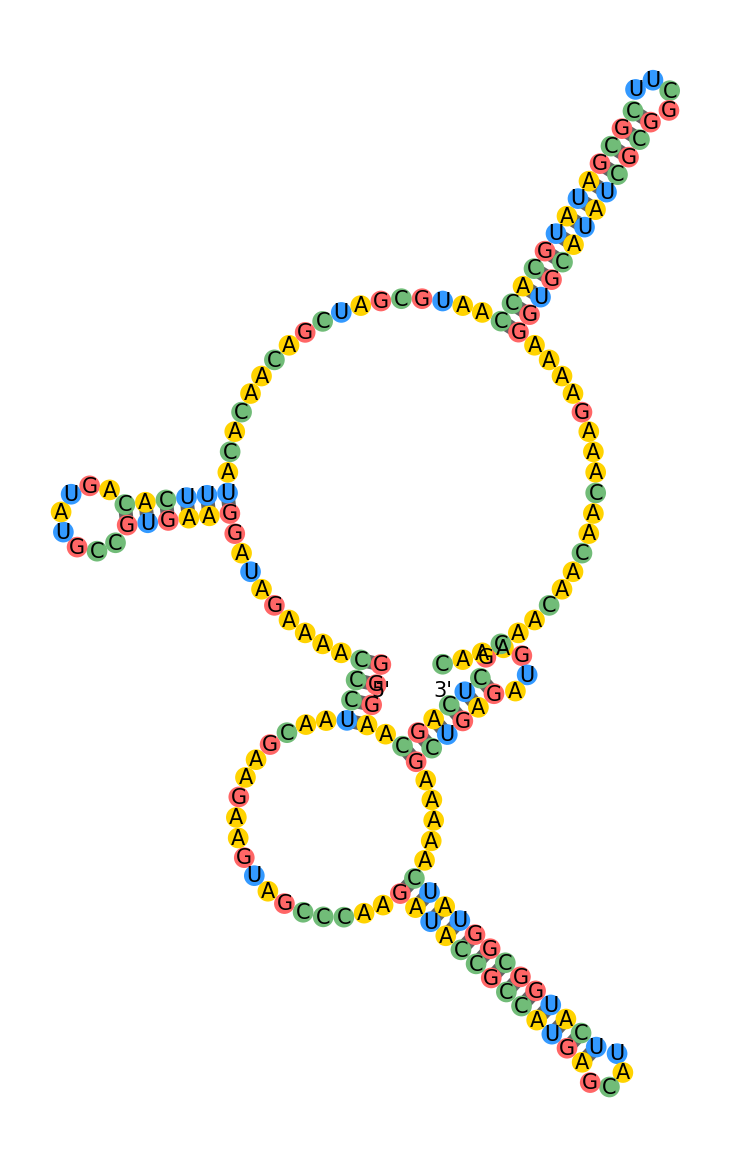

In [9]:
seq = RNA_seq_train[0]
struct = RNA_struct_train[0]

draw_struct(seq,struct)

### GNN-AutoEncoder Model Design

In [10]:
class RNAGraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNAGraphAutoencoder, self).__init__()
        self.encoder = nn.ModuleList([
            GCNConv(input_dim, hidden_dim),
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim, latent_dim)
        ])
        
        self.decoder = nn.ModuleList([
            GCNConv(latent_dim, hidden_dim),
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim, input_dim)
        ])
        
        self.relu = nn.ReLU()
    
    def encode(self, x, edge_index):
        for layer in self.encoder:
            x = self.relu(layer(x, edge_index))
        return x
    
    def decode(self, x, edge_index):
        for layer in self.decoder:
            x = self.relu(layer(x, edge_index))
        return x
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Encoding
        latent = self.encode(x, edge_index)
        
        # Decoding
        reconstructed = self.decode(latent, edge_index)
        
        return reconstructed, latent


In [11]:
input_dim = 7  # 4 for bases + 3 for structure
hidden_dim = 64
latent_dim = 32
model = RNAGraphAutoencoder(input_dim, hidden_dim, latent_dim)


In [2]:
import os 
print(os.getcwd())

/home/ec2-user/internship/modeling/GNN_autoencoder


### Train the Model

In [12]:
# Create data loader
batch_size = 64
data_loader = DataLoader(graphs_train, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(graphs_val, batch_size=32, shuffle=False)

/home/ec2-user/miniconda3/envs/betorch/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        # Forward pass
        reconstructed, _ = model(batch)
        # Compute loss
        loss = criterion(reconstructed, batch.x)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            reconstructed, _ = model(batch)
            loss = criterion(reconstructed, batch.x)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, data_loader, criterion, optimizer)
    val_loss = validate(model, val_data_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("GNN-AutoEncoder training completed!")

Epoch 1/50, Training Loss: 0.1297, Validation Loss: 0.1162
Epoch 2/50, Training Loss: 0.1126, Validation Loss: 0.1093
Epoch 3/50, Training Loss: 0.1074, Validation Loss: 0.1060
Epoch 4/50, Training Loss: 0.1046, Validation Loss: 0.1034
Epoch 5/50, Training Loss: 0.1024, Validation Loss: 0.1020
Epoch 6/50, Training Loss: 0.1010, Validation Loss: 0.1002
Epoch 7/50, Training Loss: 0.0996, Validation Loss: 0.0989
Epoch 8/50, Training Loss: 0.0977, Validation Loss: 0.0965
Epoch 9/50, Training Loss: 0.0955, Validation Loss: 0.0948
Epoch 10/50, Training Loss: 0.0937, Validation Loss: 0.0941
Epoch 11/50, Training Loss: 0.0920, Validation Loss: 0.0916


KeyboardInterrupt: 

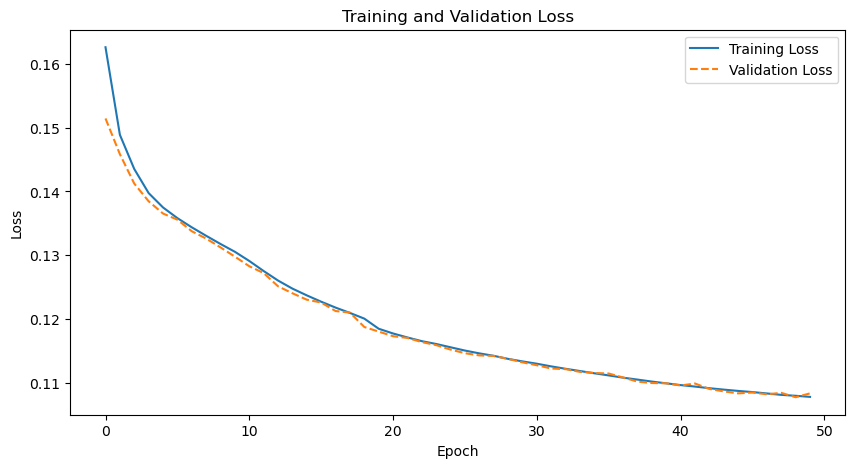

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [32]:
# Save the trained model
torch.save(model.state_dict(), "rna_graph_autoencoder_model.pth")

In [51]:
model.eval()

RNAGraphAutoencoder(
  (encoder): ModuleList(
    (0): GCNConv(7, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 32)
  )
  (decoder): ModuleList(
    (0): GCNConv(32, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 7)
  )
  (relu): ReLU()
)

In [58]:
total_loss = 0
model.eval()
with torch.no_grad():
    for data in data_loader:
        reconstructed, _ = model(data)
        loss = criterion(reconstructed, data.x)  
        total_loss += loss.item()

average_loss = total_loss / len(data_loader)
print("Average Reconstruction Loss:", average_loss)

Average Reconstruction Loss: 0.2807197823328866


In [59]:
# Function to extract features using the trained model
def extract_features(model, loader):
    model.eval()
    features = []
    
    with torch.no_grad():
        for batch in loader:
            _, latent = model(batch)
            features.append(latent)
    
    return torch.cat(features, dim=0)

# Extract features for all graphs
feature_loader = DataLoader(graphs_test, batch_size=batch_size, shuffle=False)
extracted_features = extract_features(model, feature_loader)

print(f"Extracted features shape: {extracted_features.shape}")

Extracted features shape: torch.Size([4888923, 32])


In [61]:
extracted_features[0]

tensor([0.0000, 0.0309, 0.0505, 0.0000, 0.0004, 0.0000, 0.0000, 0.1748, 0.0000,
        0.1792, 0.0000, 0.0532, 0.1087, 0.1028, 0.0120, 0.0658, 0.0000, 0.0617,
        0.2599, 0.2812, 0.0000, 0.0862, 0.0000, 0.1406, 0.0000, 0.0362, 0.0000,
        0.1805, 0.0000, 0.2478, 0.0148, 0.0000])

In [1]:
import matplotlib.pyplot as plt